# The Acrobot

*We recommend you look at the [Introduction to Crocoddyl](introduction_to_crocoddyl.ipynb) example before this one.*

In the example, we model the acrobot control problem using Crocoddyl. An acrobot is a two joint planar robot with only one actuator. It is a canonnical example of an underactuated system and so presents an interesting control problem.

We demonstrate how to:

1. Load a model from an urdf.
1. Define an actuation mapping for the system.
1. Construct and solve the control problem.

## Loading the model
A standalone double pendulum robot urdf is provided in the [example-robot-data](https://github.com/Gepetto/example-robot-data) repository, this comes bundled with Crocoddyl. Let's load the model and inspect its properties.

In [7]:
import os
import sys
import numpy as np
import pathlib
import crocoddyl
import pinocchio

# Get the path to the urdf
from example_robot_data.path import EXAMPLE_ROBOT_DATA_MODEL_DIR

urdf_model_path = pathlib.Path(
    "double_pendulum_description", "urdf", "double_pendulum_simple.urdf"
)
urdf_model_path = os.path.join(EXAMPLE_ROBOT_DATA_MODEL_DIR, urdf_model_path)

# Now load the model (using pinocchio)
robot = pinocchio.robot_wrapper.RobotWrapper.BuildFromURDF(str(urdf_model_path))

# The model loaded from urdf (via pinicchio)
print(robot.model)

# Create a multibody state from the pinocchio model.
state = crocoddyl.StateMultibody(robot.model)

Nb joints = 3 (nq=2,nv=2)
  Joint 0 universe: parent=0
  Joint 1 joint1: parent=0
  Joint 2 joint2: parent=1



`pinocchio` comes with some handy wrappers that load a robot along with vizual and collision models. These are all defined via that urdf. `robot.model` is the model is a model of the DAEs (Differential Algebraic Equations).

You will notice that the there are two joint configurations `nq` and velocities `nv`.

## Actuation Mapping
In order to create an underactuated double pendulum, the acrobot, we will create mapping between control inputs and joint torques. This is done by inheriting from `ActuationModelAbstract`. See also `ActuationModelFloatingBase` and `ActuationModelFull` for other options.

In [8]:
# Define the control signal to actuated joint mapping
class AcrobotActuationModel(crocoddyl.ActuationModelAbstract):
    def __init__(self, state):
        nu = 1  # Control dimension
        crocoddyl.ActuationModelAbstract.__init__(self, state, nu=nu)

    def calc(self, data, x, u):
        assert len(data.tau) == 2
        # Map the control dimensions to the joint torque
        data.tau[0] = u
        data.tau[1] = 0

    def calcDiff(self, data, x, u):
        # Specify the actuation jacobian
        data.dtau_du[0] = 1
        data.dtau_du[1] = 0


# Also see ActuationModelFloatingBase and ActuationModelFull
actuationModel = AcrobotActuationModel(state)

## Constructing the Problem

Before we solve the control problem, we need to construct the cost models and action models.

In [9]:
dt = 1e-3  # Time step
T = 1000  # Number of knots

# Cost models
runningCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)

# Add a cost for the configuration positions and velocities
xref = np.array([0, 0, 0, 0])  # Desired state
stateResidual = crocoddyl.ResidualModelState(state, xref=xref, nu=actuationModel.nu)
stateCostModel = crocoddyl.CostModelResidual(state, stateResidual)
runningCostModel.addCost("state_cost", cost=stateCostModel, weight=1e-5 / dt)
terminalCostModel.addCost("state_cost", cost=stateCostModel, weight=1000)

# Add a cost on control
controlResidual = crocoddyl.ResidualModelControl(state, nu=actuationModel.nu)
bounds = crocoddyl.ActivationBounds(np.array([-1.0 -1.0]), np.array([1.0, 1.0]))
activation = crocoddyl.ActivationModelQuadraticBarrier(bounds)
controlCost = crocoddyl.CostModelResidual(
    state, activation=activation, residual=controlResidual
)
runningCostModel.addCost("control_cost", cost=controlCost, weight=1e-1 / dt)

# Create the action models for the state
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel
    ),
    dt,
)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, terminalCostModel
    ),
    0.0,
)

RuntimeError: In /root/workspace/crocoddyl/include/crocoddyl/core/activations/quadratic-barrier.hpp
crocoddyl::ActivationBoundsTpl<Scalar>::ActivationBoundsTpl(const VectorXs&, const VectorXs&, crocoddyl::ActivationBoundsTpl<Scalar>::Scalar) [with _Scalar = double; crocoddyl::ActivationBoundsTpl<Scalar>::VectorXs = Eigen::Matrix<double, -1, 1>; crocoddyl::ActivationBoundsTpl<Scalar>::Scalar = double] 36
Invalid argument: The lower and upper bounds don't have the same dimension (lb,ub dimensions equal to 1,2, respectively)

Now we define the control problem.

In [ ]:
# Define a shooting problem
q0 = np.zeros((state.nq,))  # Inital joint configurations
q0[0] = np.pi / 2  # Down
v0 = np.zeros((state.nv,))  # Initial joint velocities
x0 = np.concatenate((q0, v0))  # Inital robot state
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

Let's test the system with a rollout.

[1.5707963267948966, 1.5709234538589896, 1.571177707978404, 1.571559089071267, 1.5720675968422442, 1.572703230566154, 1.5734659887955662, 1.574355868992415, 1.5753728670836795, 1.5765169769412275, 1.5777881897859767, 1.5791864935166002, 1.5807118719631068, 1.5823643040657454, 1.5841437629798392, 1.5860502151073315, 1.588083619056043, 1.5902439245278854, 1.5925310711375642, 1.5949449871636225, 1.5974855882340455, 1.6001527759490408, 1.6029464364440595, 1.6058664388965997, 1.608912633980859, 1.6120848522748599, 1.6153829026252622, 1.618806570475704, 1.6223556161651524, 1.6260297732034208, 1.62982874653168, 1.6337522107764813, 1.6377998085064749, 1.6419711485016788, 1.6462658040457707, 1.650683311252472, 1.655223167437618, 1.659884829548974, 1.664667712666225, 1.6695711885838456, 1.6745945844897072, 1.6797371817523088, 1.684998214829395, 1.6903768703104507, 1.6958722861051205, 1.7014835507889772, 1.7072097031172773, 1.7130497317163553, 1.7190025749611602, 1.7250671210461044, 1.73124220825

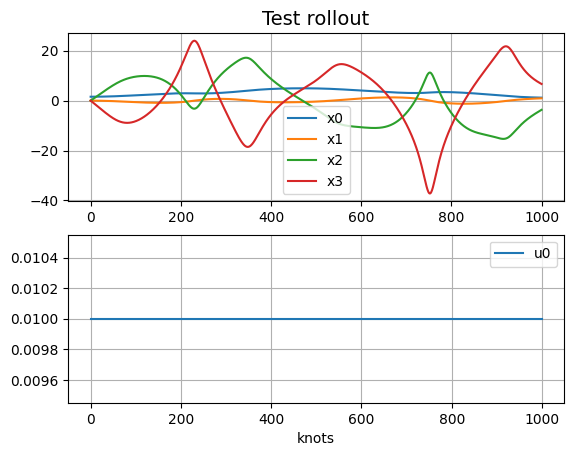

In [ ]:
# Test the problem with a rollout
us = [0.01 * np.ones((1,))] * T
xs = problem.rollout(us)

# Handy to blat up the state and control trajectories
crocoddyl.plotOCSolution(xs, us, show=False, figIndex=99, figTitle="Test rollout")

# Put a grid on the plots
import matplotlib.pyplot as plt

fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid()

Now we can solve the optimal control problem.

In [ ]:
# Now stabilize the acrobot using FDDP
solver = crocoddyl.SolverFDDP(problem)

# Solve
callbacks = []
callbacks.append(crocoddyl.CallbackLogger())
callbacks.append(crocoddyl.CallbackVerbose())
solver.setCallbacks(callbacks)
solver.solve([], [], 300, False, 1e-5)

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||    ||gfeas||    ||hfeas|| 
   0  1.30386e+00  4.74669e+00  -9.49339e+00  1.00000e-05  1.00000e-05  0.1250  1.57080e+00  0.00000e+00  0.00000e+00
   1  1.55979e+00  2.58470e+00  -4.17022e+00  1.00000e-05  1.00000e-05  0.0625  1.37445e+00  0.00000e+00  0.00000e+00
   2  1.66330e+00  1.92174e+00  -2.54595e+00  1.00000e-05  1.00000e-05  0.0625  1.28854e+00  0.00000e+00  0.00000e+00
   3  1.61667e+00  1.48001e+00  -1.46361e+00  1.00000e-05  1.00000e-05  0.0312  1.20801e+00  0.00000e+00  0.00000e+00
   4  1.56090e+00  1.45189e+00  -1.31088e+00  1.00000e-05  1.00000e-05  0.0312  1.17026e+00  0.00000e+00  0.00000e+00
   5  1.50891e+00  1.44397e+00  -1.21364e+00  1.00000e-05  1.00000e-05  0.0312  1.13369e+00  0.00000e+00  0.00000e+00
   6  1.46187e+00  1.43267e+00  -1.12678e+00  1.00000e-05  1.00000e-05  0.0312  1.09826e+00  0.00000e+00  0.00000e+00
   7  1.43103e+00  1.40776e+00  -1.03416e+00  1.00000e-05

False

We can visualize the trajectory with `meshcat` or using `gepetto-gui` (you will need to install [gepetto-viewer]() and [gepetto-viewer-corba]() and start the process in a separate terminal.)

In [ ]:
# Display using meshcat
robot_display = crocoddyl.MeshcatDisplay(robot, -1, 1, False)
display(robot_display.robot.viewer.jupyter_cell())
robot_display.displayFromSolver(solver)

# Display using gepetto-gui
if False:
    robot_display = crocoddyl.GepettoDisplay(robot, floor=False)
    robot_display.displayFromSolver(solver)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


/usr/local/lib/python3/dist-packages/pinocchio/visualize/meshcat_visualizer.py:482: UserWarning: Error while loading geometry object: base_link_0
Error message:
No to_python (by-value) converter found for C++ type: boost::shared_ptr<pinocchio::fcl::FakeCollisionGeometry>
  self.loadViewerGeometryObject(collision, pin.GeometryType.COLLISION, color)
/usr/local/lib/python3/dist-packages/pinocchio/visualize/meshcat_visualizer.py:482: UserWarning: Error while loading geometry object: link1_0
Error message:
No to_python (by-value) converter found for C++ type: boost::shared_ptr<pinocchio::fcl::FakeCollisionGeometry>
  self.loadViewerGeometryObject(collision, pin.GeometryType.COLLISION, color)
/usr/local/lib/python3/dist-packages/pinocchio/visualize/meshcat_visualizer.py:482: UserWarning: Error while loading geometry object: link2_0
Error message:
No to_python (by-value) converter found for C++ type: boost::shared_ptr<pinocchio::fcl::FakeCollisionGeometry>
  self.loadViewerGeometryObject(coll

We can plot the trajectory and the solver's convergence properties.

[1.5707963267948966, 1.5741200821624488, 1.58105032758082, 1.5918685438226179, 1.6068429071913706, 1.6262034136939385, 1.6501018172235857, 1.6785584301032506, 1.7114067042962566, 1.7482573265822183, 1.7885071429149355, 1.831403890491115, 1.8761487670955364, 1.9219980031943484, 1.9683303779425636, 2.014671507238566, 2.060685614532186, 2.106151240596493, 2.1509334748659823, 2.194959271766607, 2.2375481851290933, 2.278749517746919, 2.318617600706275, 2.3572072567175435, 2.3945712740665006, 2.4307591176915655, 2.465816387632546, 2.499784718858886, 2.532701932861397, 2.5646023242660907, 2.5955170111246035, 2.625474305755983, 2.6545000805469336, 2.6826181140065586, 2.7098504091287765, 2.736217480299575, 2.761738607564977, 2.786432058651065, 2.8103152800743345, 2.8334050592324522, 2.855717659667631, 2.8772689318378215, 2.8980744017713045, 2.9181493399533736, 2.9375088127220277, 2.9561677183473547, 2.9741408098462445, 2.9914427064469358, 3.0080878954717165, 3.024090726254776, 3.039465397558963

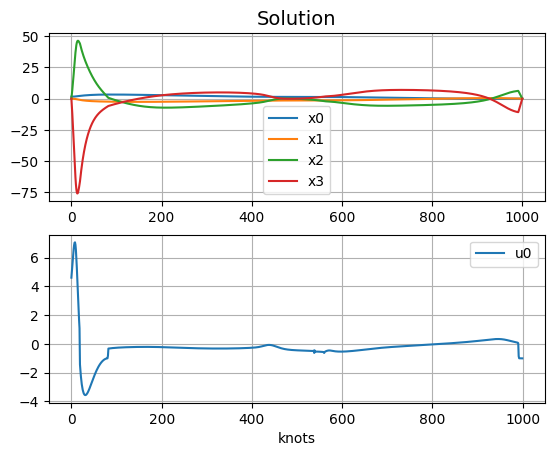

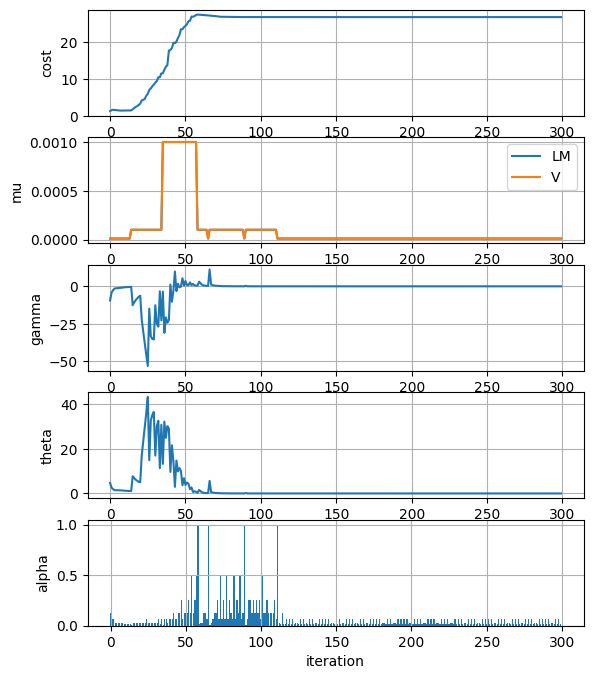

In [ ]:
# Plotting the solution and the DDP convergence
log = solver.getCallbacks()[0]

import matplotlib.pyplot as plt

crocoddyl.plotOCSolution(
    xs=log.xs, us=log.us, show=False, figIndex=1, figTitle="Solution"
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

crocoddyl.plotConvergence(
    log.costs,
    log.u_regs,
    log.x_regs,
    log.grads,
    log.stops,
    log.steps,
    show=False,
    figIndex=2,
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

plt.show()